In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

from utils.config import Config
from utils.validation import TensorModel, BatchModel
from utils.architecures import NeuralNetworkV1, NeuralNetworkV2
from utils.metrics import *
from utils.training import validation_step
from utils.plots import plot_decision_boundary

2025-07-13 20:02:13,778 - INFO - NumExpr defaulting to 11 threads.


In [2]:
hyperparameters = {
    'epochs': 100,
    'batch_size': 16,
    'hidden_size': [128, 64, 32],
    'learning_rate': 0.001,
    'n_features': 2,
    'dropout': 0.1,
    'weight_decay': 0.001
}

config = Config(hyperparameters)

2025-07-13 20:02:16,705 - INFO - Current device: mps


In [ ]:
import wandb

# Log in to Weights & Biases. This will prompt you to enter your API key if not already logged in.
wandb.login()

# Initialize Weights & Biases. This will start a new run and log the hyperparameters.
run = wandb.init(
    project='pytorch-bootcamp',
    entity='nikossacoff-development',
    name='circles-classification-5',
    config={
        'model': 'NeuralNetworkV2',
        'optimizer': 'Adam',
        'criterion': 'BCEWithLogitsLoss',
        'hyperparameters': hyperparameters
    }
)

## 1. Load data

- *Cargamos nuestros datos utilizando la función `torch.load()`. Utilizamos el modelo `Tensor` para validar nuestros tensores.*

In [3]:
# Load tensors for training, validation, and evaluation data
train_data = torch.load('temp/data/train_data.pth').to(device=config.device)
val_data = torch.load('temp/data/validation_data.pth').to(device=config.device)
eval_data = torch.load('temp/data/evaluation_data.pth').to(device=config.device)

train_data = TensorModel(tensor=train_data, tensor_dimensions=2).tensor
val_data = TensorModel(tensor=val_data, tensor_dimensions=2).tensor
eval_data = TensorModel(tensor=eval_data, tensor_dimensions=2).tensor

In [4]:
# Split data into features and labels
X_train, y_train = train_data[:, :-1], train_data[:, -1]
X_val, y_val = val_data[:, :-1], val_data[:, -1]
X_eval, y_eval = eval_data[:, :-1], eval_data[:, -1]

logging.info(f"Training data: {X_train.shape} | Labels: {y_train.shape}")
logging.info(f"Validation data: {X_val.shape} | Labels: {y_val.shape}")

2025-07-13 20:02:20,327 - INFO - Training data: torch.Size([1400, 2]) | Labels: torch.Size([1400])
2025-07-13 20:02:20,328 - INFO - Validation data: torch.Size([300, 2]) | Labels: torch.Size([300])


## 2. Build the model

- *Podemos crear nuestro modelo definiendo una capa oculta a la vez (como en la primera versión). Cuando definamos el método `forward()` vamos a tener que, explícitamente, definir el grafo computacional de nuestra red neuronal.*
- *Otra opción es utilizar el módulo `nn.Sequential`. Este módulo nos permite definir de forma implícita el grafo computacional de nuestra red neuronal.*
    - *Funciona como un contenedor en donde definimos los módulos (capas) de nuestra red neuronal en el orden que queremos que se ejecuten al llamar el método `forward()`.*
    - *Lo bueno es que no tenemos que definir el grafo computacional dentro del método `forward()`, lo que reduce considerablemente el código.* 
    - *Se puede encontrar más información en la [documentación](https://docs.pytorch.org/docs/stable/generated/torch.nn.Sequential.html).*

In [ ]:
class NeuralNetworkV0(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, device: torch.device):
        super().__init__()
        self.layer_1 = nn.Linear(input_size, hidden_size)
        self.layer_2 = nn.Linear(hidden_size, 1)
        
        self.to(device)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        try:
            # Pass the input tensor through the first layer
            x = self.layer_1(x)
            # Apply the ReLU activation function
            x = torch.relu(x)
            # Pass the output of the first layer through the second layer
            x = self.layer_2(x)
            # Apply the sigmoid activation function for binary classification
            x = torch.sigmoid(x)

            return x
        except Exception as error:
            print(error)

class NeuralNetworkV0(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, device: torch.device):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
        self.to(device)
    
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return self.model(X)

In [ ]:
# Instantiate the model
model = NeuralNetworkV2(
    input_size=config.n_features,
    hidden_size=config.hidden_size,
    dropout=config.dropout,
    device=config.device
)

### 2.1. Architecture

⚠️ WIP: Explicación de la estructura de la red neuronal y los cálculos matemáticos que ocurren detrás.

<img src="attachments/simple-linear-nn.png" width="600" height="600" style="display: block; margin: 0 auto;" />

### 2.2. Loss function

- *Dado que este es un problema de clasificación binaria, vamos a utilizar la Binary Cross-Entropy como función de pérdida.*
- *PyTorch tiene disponibles dos módulos para esta función de pérdida: `torch.nn.BCELoss` y `torch.nn.BCELossWithLogits`. La única diferencia entre ambos módulos es que `torch.nn.BCELossWithLogits` recibe los scores del modelo y con eso computa las probabilidades (pasando los scores por la función activación Sigmoidea) y luego computa la log-verosimilitud, mientras que `torch.nn.BCELoss` solo computa la log-verosimilitud (i.e., recibe las probabilidades).*
- *Lo recomendable es utilizar `torch.nn.BCELossWithLogits` por dos razones:*
    1. *Nos ahorramos de definir la función de activación dentro de nuestro modelo.*
    2. *Computar las probabilidades (i.e., pasar los scores por la función de activación) y luego aplicar logaritmos suele ser una operación muy inestable numéricamente. Al calcular todo al mismo tiempo, reducimos las inestabilidades.*

In [ ]:
criterion = nn.BCEWithLogitsLoss()

### 2.1. Optimizador

In [ ]:
optimizer = optim.Adam(
    params=model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

### 2.2. DataLoaders

- *`torch.utils.data.DataLoader` es un objeto de PyTorch que nos permite iterar sobre nuestros conjunto de datos de manera eficiente.*
- *Nos permiten generar batches (i.e., particionar nuestro conjunto de datos en muestras más pequeñas) y paralelizar el procesamiento de los datos, entre otras cosas.*
- *Se construyen a partir de un objeto `torch.utils.data.Dataset`. Esta es una clase abstracta que define la lógica de como acceder y, si es necesario, transformar los datos crudos. Se pueden crear módulos (que heredan las funcionalidades de la clase `torch.utils.data.Dataset`) o se pueden utilizar alguno de los módulos ya disponibles.*
- *Más información sobre esto en la [documentación](https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).*

In [5]:
# Create a TensorDataset instante for the training data and validation data
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
eval_dataset = TensorDataset(X_eval, y_eval)

# Create DataLoaders for the training and validation datasets
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
eval_loader = DataLoader(eval_dataset, batch_size=config.batch_size, shuffle=False)

### 2.3. Training Loop

- *Cada cinco pasos (i.e., después de actualizar cinco veces los pesos de nuestra red) calculamos las métricas de validación. De esta manera podemos entender si el modelo está aprendiendo a generalizar a los datos o simplemente está memorizando.*
- *Como es un problema de clasificación, además de calcular la función de pérdida para la muestra de entrenamiento y de validación, vamos a calcular las siguientes métricas:*
    - **Accuracy**. *Número de observaciones que nuestro modelo clasificó correctamente sobre el total de observaciones.*
    - **Precision**. *Número de observaciones que clasificamos correctamente como positiva (i.e., $y=1$) sobre el total de observaciones que clasificamos como positivas. Es una medida de que tan eficiente es nuestro modelo. Al maximizar la precision reducimos los falsos positivos.*
    - **Recall**. *Número de observaciones que clasificamos correctamente como positiva (i.e., $y=1$) sobre el total las observaciones que eran positivas. Es una medida de que tanto logra capturar nuestro modelo. Al maximizar la recall reducimos los falsos negativos.*
    - **F1-Score**. *Es la media armónica entre la eficiencia (precision) y la captura (recall). Nos dice que tan bien balancea nuestro modelo los falsos positivos y los falsos negativos.*
- *También vamos a calcular otras métricas que nos suelen ayudar a entender si el modelo está generalizando bien a los datos o no:*
    - **Weight-norm**. *Normalizamos los pesos.*
        - *Un incremento en los pesos del modelo puede derivar en un modelo que no generaliza correctamente a los datos. El hacer un seguimiento de los pesos durante el entrenamiento nos permite investigar y entender si nuestro modelo está sobreajustando o no a los datos.*
        - *Weight-decay es un método de regularización que nos permite reducir el tamaño de los pesos para evitar el sobreajuste. Podemos evaluar su impacto al hacer un seguimiento de los pesos durante el entrenamiento.*
    - **Gradient-norm**. *Normalizamos los gradientes.*
        - *Los gradientes de la función de pérdida con respecto a los pesos del modelo nos indican la dirección de mayor crecimiento (nosotros nos queremos mover en la dirección contraria). Por lo general, no nos interesa la magnitud de los gradientes, solo nos interesa la dirección en la que nos tenemos que mover. Se suelen normalizar los gradientes para obtener una mayor estabilidad durante el entrenamiento del modelo, aunque no siempre es la mejor opción (más información en este [posteo](https://stats.stackexchange.com/questions/22568/difference-in-using-normalized-gradient-and-gradient)).*
        - *Cosas a tener en cuenta:*
            - *Si observamos que la norma de los gradientes es muy cercana a cero (i.e., los gradientes son cercanos a cero), entonces tenemos un problema de vanishing gradients. Si eso ocurre, entonces no estamos actualizando los pesos y, por ende, el modelo deja de aprender.*
            - *Si observamos que la norma de los gradientes es muy grande (i.e., los gradientes están creciendo mucho), entonces tenemos un problema de exploding gradients. Esto nos puede alertar de posibles inestabilidades durante el entrenamiento.*
            - *Una caída abrupta puede reflejar una convergencia prematura o que el modelo haya llegado a un mínimo local o saddle-point.*

In [ ]:
# Count the number of steps. We will validate the model every 5 steps.
step = 0

# Accumulate the training loss 
train_loss_accum = 0.0

# Accumulate the validation loss.
validation_loss_accum = 0.0

# Count the number of epochs without improvement.
# If the validation loss is lower than the best validation loss (minus a small delta value), we reset the counter to 0.
# If the validation loss is not lower than the best validation loss, we increment the counter by 1. When counter = patience, we stop the training.
counter = 0
best_val_loss = float('inf')

for epoch in np.arange(config.epochs):
    # Accumulate the training and validation loss 
    train_loss_accum = 0.0
    validation_loss_accum = 0.0

    for (X_train, y_train) in train_loader:
        ### Training phase
        
        # Set model to training mode
        model.train()
        
        # Forward pass.
        # The loss function expects the shape of the model's output to be the same as the ground truth.
        # Since this is a binary classification problem, the ground truth tensor is of shape (N,)
        # We use .squeeze() to ensure the model's output is also of shape (N,).
        outputs = model(X_train)
        outputs = outputs.squeeze()

        # Compute the loss
        train_loss = criterion(outputs, y_train.float())
        # Accumulate the training loss
        train_loss_accum += train_loss.item()

        # Zero the gradients
        optimizer.zero_grad()

        # Backward pass
        train_loss.backward()

        # Calculate the norm of the gradients. We don't clip the gradients here, but you can do so if needed.
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Calculate the norm of the weights
        weight_norm = torch.norm(torch.stack([torch.norm(param) for param in model.parameters()]))

        # Log the gradients and weights norms
        run.log({
            'Metrics/Gradient norm': grad_norm,
            'Metrics/Weight norm': weight_norm
        })

        # Update the weights
        optimizer.step()

    ### Inference phase
    val_results = validation_step(
        model=model,
        dataloader=val_loader,
        criterion=criterion,
        device=config.device
    )

    run.log({
        'Metrics/Accuracy': val_results['accuracy'],
        'Metrics/Precision': val_results['precision'],
        'Metrics/Recall': val_results['recall'],
        'Metrics/F1-Score': val_results['f1_score']
    })

    # Average the training and validation loss
    train_loss = train_loss_accum / len(train_loader)

    # Log the training loss for the whole epoch
    run.log({
        'Loss/Training': train_loss,
        'Loss/Validation': val_results['loss']
    })

    if (epoch + 1) % 5 == 0:
        logging.info(f"Epoch: {epoch + 1}/{config.epochs} | Training loss: {train_loss:.4f} | Validation loss: {val_results['loss']:.4f}")
        logging.info(f"Epoch: {epoch + 1}/{config.epochs} | Accuracy: {val_results['accuracy']:.4f} | F1-Score: {val_results['f1_score']:.4f}\n")

In [ ]:
# Save model
torch.save(model.state_dict(), 'temp/models/neural-network-v2.pth')

# Generate a wandb artifact
model_artifact = wandb.Artifact(
    name='neural-network-v2',
    type='model',
    metadata={
        'input_size': config.n_features,
        'hidden_size': config.hidden_size,
        'epochs': config.epochs,
        'batch_size': config.batch_size,
        'learning_rate': config.learning_rate,
        'dropout': config.dropout,
        'weight_decay': config.weight_decay
    }
)

model_artifact.add_file('temp/models/neural-network-v2.pth', name='model.pth')
run.log_artifact(model_artifact)

In [ ]:
run.finish()  # Finish the Weights & Biases run

Text(0.5, 1.0, 'Test')

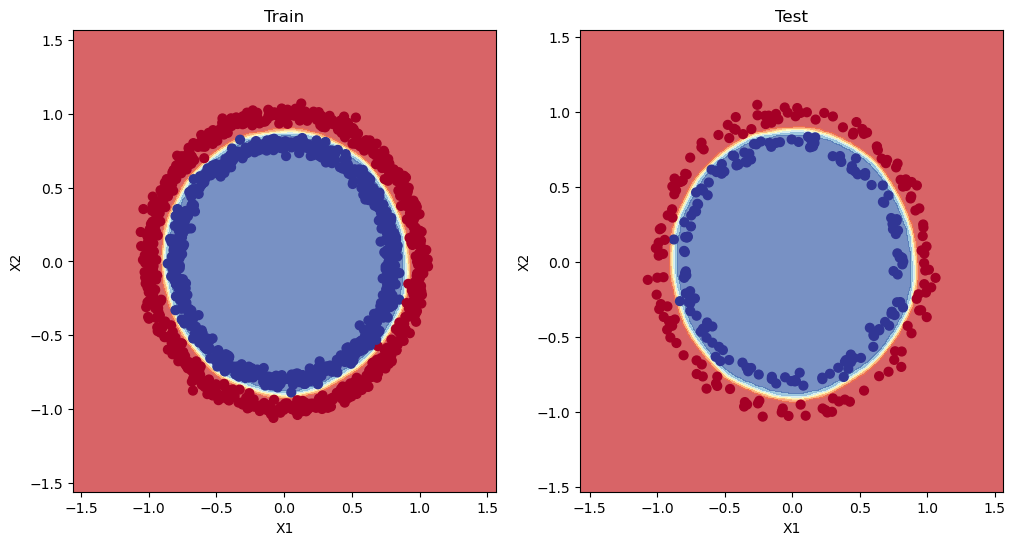

In [6]:
# Instantiate the model for plotting decision boundaries
model = NeuralNetworkV2(
    input_size=config.n_features,
    hidden_size=config.hidden_size,
    dropout=config.dropout,
    device=config.device
)

# Load the weights from the saved model
state_dict = torch.load('temp/models/neural-network-v2.pth')

# Load the state dictionary into the model
model.load_state_dict(state_dict)

# Plot the decision boundary for the training and test datasets
fig, ax = plt.subplots(figsize=(12, 6), ncols=2)

plot_decision_boundary(model, X_train, y_train, ax=ax[0])
ax[0].set_title("Train")
plot_decision_boundary(model, X_eval, y_eval, ax=ax[1])
ax[1].set_title("Test")